# Hipps-Dimes Walkthrough

Pre-requisites:

* Basic Python knowledge
* Some experience with the Numpy and Scipy

To navigate this notebook:

* First install the python script/module by running `pip install --editable .` in the terminal
* Click on a code cell and execute its code by pressing `shift+enter` or clicking the `play` button on the toolbar
* During the execution of the code cell, the prompt on the left is displayed as `[*]:`. It will display the execution count when the execution is finished.
* The output of each code cell is displayed below each cell

---

**First, install the Hipps-Dimes module by running the following code cell**

In [1]:
%%bash

pip install --editable .

Obtaining file:///run/media/jiamengguang/Main/Users/jiameng_guang/Dropbox/Documents/Work-Document/code/HIPPS-DIMES
  Attempting uninstall: HippsDimes
    Found existing installation: HippsDimes 1.0
    Uninstalling HippsDimes-1.0:
      Successfully uninstalled HippsDimes-1.0
  Running setup.py develop for HippsDimes


**Next, we can display the help information for available arguments and options the script accepts by using `--help` option**

In [2]:
%%bash

HippsDimes --help

Usage: HippsDimes [OPTIONS] INPUT OUTPUT_PREFIX

  Script to run HIPPS/DIMES to generate ensemble of genome structures from
  either contact map or mean distance map

  INPUT: Specify the path to the input file

  OUTPUT_PREFIX: Specify the prefix for output files

  Reference: https://www.biorxiv.org/content/10.1101/2020.05.21.109421v1

Options:
  -e, --ensemble INTEGER        specify the number of conformations generated
                                [default: 1000]

  -a, --alpha FLOAT             specify the value of cmap-to-dmap conversion
                                exponent  [default: 4.0]

  -s, --selection TEXT          specify which chromosome or region to run the
                                model on if the input file is Hi-C data in
                                cooler format. Accept any valid options for
                                [fetch] method in cooler.Cooler.matrix()
                                selector

  -i, --iteration INTEGER       [default: 100

---

## Overview

The program `HippsDimes` accept a input file, which can be either a Hi-C contact map or mean spatial distance map, and then generate an ensemble of structures of x, y, z coordinates of genomic loci.

If the input file is a Hi-C contact map, then it can be either [`cooler`](https://open2c.github.io/cooler/) format or pure text format. If the input file is a mean spatial distance map, then it should be pure text format.

The program accepts a number of arguments and options. The full list of arguments and options and their descriptions are the following,

### Argument

- `INPUT`: File path for the input file. The input file can be a Hi-C contact map or a mean spatial distance map as measured in Multiplexed FISH experiment.
- `OUTPUT_PREFIX`: Prefix for outputfiles. For instance, if one specify it to be `TEST`, then all the output files will start with `TEST_`.

### Options

- `-e` or `--ensemble`: Number of individual conformations to be generated. This script will generate an ensemble of structures consistent with the input Hi-C contact map or the mean spatial distance map. Each individual conformations are different from each other. You can specify how many such individual conformations you want to generate.
- `-a` or `--alpha`: Value of the contact map to distance map conversion exponent. If the input file is Hi-C contact map, the method first convert the contact map to a mean spatial distance map. The equation of the conversion is d_{ij} ~ c_{ij}^{1/\alpha}. The default value of \alpha is 4.0, estimated in this work 10.1126/science.aaf8084
- `-s` or `--selection`: Specify chromosome or region. This option only works when the input file has [`cooler`](https://github.com/open2c/cooler) format. The value of this option is passed to the `cooler.Cooler.matrix().fetch()` method. For details, please refer their [documentation](https://cooler.readthedocs.io/en/latest/concepts.html#matrix-selector)
- `-i` or `--iteration`: The method relies on iterative scaling to find the optimal parameters. This option specifies the number of iterations. Generally, the more iterations the model runs, the better results are. However, the convergence of the model slow down when iteration increases. For larger size of contact map and the mean distance map, the number of iterations needed to good convergence is larger.
- `-r` or `--learning-rate`: The learning rate for iterative scaling. Higher learning rate achieves faster convergence. However, the model can crash if learning rate is too large. The default value is 10. One should play around this option to see what works best.
- `--input-type`: The type of the input file. To use the script, the type must be specified. The method can work on both the contact map (`cmap`) or distance map (`dmap`).
- `--input-format`: The format of the input file. If the type of input file is Hi-C contact map, then the script support `cooler` format Hi-C contact map file or a pure text based file. In the text based file, each line corresponds to the row of the contact map. If the type of input file is mean distance map, then the script only support the text based file in which each line represents the row of the mean distance map.
- `--log`: A log file will be written if this option is specified. The log file contains the data of cost versus iteration
- `--no-xyzs`: Turn off writing x,y,z coordinates of genome structures to files.

---

## Examples

To run the examples below, let's import packages we will need. Install any packages which are not installed, using either `pip` or `conda`.

In [3]:
import cooler
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

First, let's import the exampled cooler file under the directory `data` and plot it

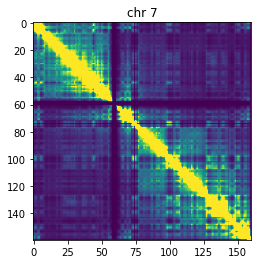

In [4]:
# import cooler file using Cooler package
cmap = cooler.Cooler('data/Rao2014-GM12878-MboI-allreps-filtered.1000kb.cool')
cmap_chr7 = cmap.matrix(balance=False).fetch('chr7')

# plot the Hi-C contact map for chromosome 7
fig, ax = plt.subplots()
ax.imshow(cmap_chr7, vmax=10000)
ax.set_title('chr 7')
plt.show()

Now, let's run the Hipps-Dimes algorithm on this Hi-C contact map and generate an ensemble of structures.

In [5]:
%%bash

HippsDimes data/Rao2014-GM12878-MboI-allreps-filtered.1000kb.cool rao2014 --input-type cmap --input-format cooler -s chr7 -e 1000 -i 1000 --log

100%|██████████| 1000/1000 [00:05<00:00, 172.90it/s]


The command above dows the following,

* specify the path to the input file `data/Rao2014-GM12878-MboI-allreps-filtered.1000kb.cool`. This argument is **required**
* specify the output prefix to be `rao2014`. All the output files' name will start with `rao2014_`. This argument is **required**
* specify that the type of the input file is `cmap` which indicates that it is a contact map. This option is **required**
* specify that the format of the input contact map is `cooler`. This option is **required**
* specify the number of individual conformations to be 1000. This option is **optional**. If without specified, default value is 1000
* specify the number of iterations to be 1000. This option is **optional**. If without specified, default value is 10000
* specify the genome region for the structures to be `chr7` which means Chromosome 7. This option is **required**
if the input file is in `cooler` format.
* turn on the log file. Once the program ran successfully, a log file named `cost_function_iteration.csv` will be generated. This option is **optional**

For more details of all the supported arguments and options, please use `HippsDimes --help` to display the help information.

Let's have a look at the results generated. The output files are,

* `rao2014.xyz`: A `.xyz` formated trajectory file containing 10 sets of x,y,z coordinates of genomic loci
* `rao2014_dmap_final.txt`: A text foramted mean distance matrix map for the end of iterations.
* `rao2014_connectivity_matrix.txt`: A text formated file containing the matrix of $k_{ij}$
* `cost_function_iteration.csv`: A CSV formatted file containing the cost value for each step of iterations.

First, we can plot the `cost_function_iteration.csv` to see the cost as a function of iteration steps,

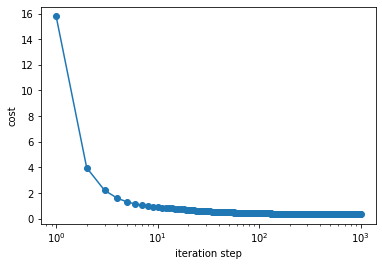

In [6]:
# read the file
cost_iteration = pd.read_csv('cost_function_iteration.csv')

# plot
fig, ax = plt.subplots()
ax.plot(cost_iteration['iteration'],\
       cost_iteration['cost'], marker='o')
ax.set_xscale('log')
ax.set_xlabel('iteration step')
ax.set_ylabel('cost')
plt.show()

As one can see, the cost goes down as the iteration step increases. Typically, for larger size of input contact map or distance map, the higher number of iteration steps for good convergence (low cost value) is needed. In this particular case, since our size of contact map is only 160x160, thus 1000 iteration steps are good enough.

Next, let's read the _simulated_ contact map and plot it side by side with the inputted Hi-C map,

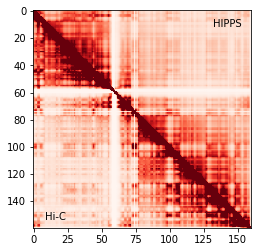

In [7]:
# load the contact map from the generated structures
cmap_model = np.loadtxt('rao2014_cmap_final.txt')

# plot the contact map from the model with the Hi-C contact map as comparison
# the lower triangle is the Hi-C map
# the upper triangle is the contact map from generated structures
fig, ax = plt.subplots()
ax.imshow(np.triu(cmap_model)+np.tril(cmap_chr7/cmap_chr7.max()), vmax=0.01, cmap=plt.cm.Reds)
ax.text(0.1,0.05,'Hi-C',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.text(0.89,0.94,'HIPPS',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.show()

The generated structures are stored in the generated `.xyz` file. Because we specify that we want 1000 individual structures, the `xyz` file contains 1000 sets of coordinates. It can be read by `VMD` or other compatible rendering softwares for visualization. Please see the recording below for an demonstration. For detailed guide how to use VMD, please visit their website https://www.ks.uiuc.edu/Research/vmd/

![vmd_demonstration](data/vmd_demonstration.gif "segment")